In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import openpyxl
import os

#### Section 4.4 Reprofiling the LRI dataset using the revised workflow

Prepared by: G Patlewicz <br>
Revised: 15th August 2022 <br>
Revised to address and clarify connection to associated manuscript

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

Accessing the LRI dataset of 45000 substances

In [28]:
lri = pd.read_csv(raw_dir+'LRI_TTC_updated_180719.csv')

In [29]:
lri.head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,kroes_decision,small_httk,large_cerapp,mark_ttc_class,reason_for_NA,old_ttc_class
0,72-20-8,DTXSID6020561,Endrin,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,99,NaN,0.000291,0.002280,0.000003,Genotoxicity Alert,Negligible risk (low probability of a life-tim...,YES,NO,Genotoxicity Alert,NaN,Genotoxicity Alert
1,60-57-1,DTXSID9020453,Dieldrin,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,99,NaN,0.000553,0.009572,0.000003,Genotoxicity Alert,Negligible risk (low probability of a life-tim...,YES,NO,Genotoxicity Alert,NaN,Genotoxicity Alert
2,87818-31-3,DTXSID3034456,Cinmethylin,CC(C)C12CCC(C)(O1)C(C2)OCC1=C(C)C=CC=C1,99,NaN,0.050130,0.445990,0.001500,Cramer Class III,Substance would not be expected to be a safety...,YES,NO,Class III,NaN,Class III
3,76738-62-0,DTXSID2024242,Paclobutrazol,CC(C)(C)C(O)C(CC1=CC=C(Cl)C=C1)N1C=NC=N1,99,NaN,0.239110,2.872300,0.001500,Cramer Class III,Substance would not be expected to be a safety...,YES,NO,Class III,NaN,Class III
4,87674-68-8,DTXSID4032376,Dimethenamid,COCC(C)N(C(=O)CCl)C1=C(C)SC=C1C,99,NaN,1.564200,15.084000,0.000003,Genotoxicity Alert,Negligible risk (low probability of a life-tim...,YES,NO,Genotoxicity Alert,NaN,Genotoxicity Alert


Creating a dict of the IDs and the smiles to prepare a dict of molecules using RDkit

In [30]:
lri_dict = { k:v for (k,v) in zip(lri['DTXSID'], lri['smiles'])}

In [31]:
len(lri_dict)

45038

In [32]:
lri_smiles = {k:Chem.MolFromSmiles(v) for k,v in lri_dict.items()}

RDKit WARNING: [17:09:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:09:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:09:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:09:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:09:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:09:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:09:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:09:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:09:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:09:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:09:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:09:05] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:09:05] WARNING: not r

In [36]:
lri_smi = {k:v for k,v in lri_smiles.items() if v is not None}

In [37]:
len(lri_smi)

45037

Accessing the cohort of concern that is specified in FDA's SOP - this includes the usual COC that are outlined in the Kroes workflow plus several others. Compiled a list based on the Enoch et al (2011) DNA alerts and the Benigni Bossa alerts in addition to a handful of additional SMARTs either reflected in the Kroes workflow or added by me for dioxin like substances

In [39]:
fda_coc = pd.read_excel(raw_dir+'FDA_COC.xlsx', sheet_name = 'FDA_COC')

In [42]:
fda_coc = fda_coc.iloc[:, :5]

In [43]:
fda_dict = {}
for i,group in fda_coc.groupby('COC'):
    key = [name for name in group['COC'] if name!=' '][0]
    value = set(group['SMARTS'])
    fda_dict[key]=value

In [44]:
len(fda_dict)

17

In [45]:
fda_smarts = {k:[Chem.MolFromSmarts(e) for e in v] for k,v in fda_dict.items()}

RDKit ERROR: [17:14:23] SMARTS Parse Error: syntax error while parsing: [$([NX3H2][NX3]([#1,#6;!$([CX3](=[OX1])[#1,#6])_100])[#1,#6;!$([CX3](=[OX1])[#1,#6])_100 show full SMARTS
RDKit ERROR: [17:14:23] SMARTS Parse Error: Failed parsing SMARTS '[$([NX3H2][NX3]([#1,#6;!$([CX3](=[OX1])[#1,#6])_100])[#1,#6;!$([CX3](=[OX1])[#1,#6])_100 show full SMARTS' for input: '[$([NX3H2][NX3]([#1,#6;!$([CX3](=[OX1])[#1,#6])])[#1,#6;!$([CX3](=[OX1])[#1,#6]) show full SMARTS'
RDKit ERROR: [17:14:23] SMARTS Parse Error: syntax error while parsing: [OX2]1[CX4]([#1,c,$([CH3])_100,$([CH2][CH3])_101,$([CH2][CH2][CH3])_102,$([CH]([CH3])[CH3])_103, show full SMARTS
RDKit ERROR: [17:14:23] SMARTS Parse Error: Failed parsing SMARTS '[OX2]1[CX4]([#1,c,$([CH3])_100,$([CH2][CH3])_101,$([CH2][CH2][CH3])_102,$([CH]([CH3])[CH3])_103, show full SMARTS' for input: '[OX2]1[CX4]([#1,c,$([CH3]),$([CH2][CH3]),$([CH2][CH2][CH3]),$([CH]([CH3])[CH3]), show full SMARTS'


In [47]:
fda_smarts.keys()

dict_keys(['Aflatoxin', 'Azo', 'Azoxy', 'Benzidine', 'Hydrazine', 'Metals_other', 'Nitroso', 'OPs', 'Polycyclic_amines', 'Steroid', 'Triazines', 'alpha_nitro_furyl', 'biphenyl', 'carbamates', 'dibenzodioxin', 'dibenzofuran', 'strained_heteronuclear_rings'])

In [52]:
SA_with_errors = []
for k,v in fda_smarts.items():
    if None in fda_smarts[k]:
        SA_with_errors.append(k)
        


In [53]:
SA_with_errors

['Hydrazine', 'strained_heteronuclear_rings']

Some errors in translation from SMARTS to RDKit - removed value elements that are None to avoid later problems in processing

In [104]:
fda_sms = {k:list(filter(None, fda_smarts[k])) for k,v in fda_smarts.items() }

First use one of three new filters to remove metals but not salts that contain one of several essential metals

Also tag OPs that are inorganic

In [110]:
def has_metal_atom(smiles):
    metal_dict = {'Na': 11 , 'Mg': 12, 'Si': 14, 'K':19, 'Ca':20, 'Mn':25, 'Fe':26, 'Cu':29, 'Zn':30, 'Co':27, 'Ni':28, 'As': 33, 'Cr':24, 'Hg':80, 'Pb':82, 'V':23, 'Al':13, 'Ag':47, 'Cd':48, 'B':5, 'Ti': 22, 'Se': 34, 'Sn': 50, 'Sb':51, 'Be': 4, 'Zr': 40, 'Nb': 41, 'Mo': 42, 'Te':52, 'Ba':56, 'W':74, 'Au': 79, 'Bi': 83}
    essential_metal_dict = {'Na': 11 , 'K':19,'Mg': 12,  'Ca':20, 'Fe':26,  'Mn':25, 'Co':27, 'Cu':29, 'Zn':30, 'Mo': 42}
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return any(atom for atom in mol.GetAtoms() if atom.GetAtomicNum() in list(metal_dict.values()))

In [111]:
def metal_ions(smiles):
    essential_metal = ['[Na+]', '[K+]', '[Mg++]',  '[Ca++]', '[Fe+3]',  '[Mn++]', '[Co+]', '[Cu++]', '[Zn++]', '[Mo++]']
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return any(mol.HasSubstructMatch(Chem.MolFromSmarts(e)) for e in essential_metal)

In [112]:
def P_inorg(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return mol.HasSubstructMatch(Chem.MolFromSmarts('[OH]P(=[O])([OH])[OH]'))

In [113]:
metal_salt = []
for x in lri['smiles']:
    is_metal_salt = metal_ions(x)
    metal_salt.append(is_metal_salt)
lri['metal_salts'] = metal_salt

RDKit WARNING: [17:45:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:23] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:23] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:24] WARNING: not r

In [114]:
metals = []
for x in lri['smiles']:
    is_inorg = has_metal_atom(x)
    metals.append(is_inorg)
lri['inorgs'] = metals

RDKit WARNING: [17:45:31] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:31] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:34] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:34] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:35] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:35] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:35] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:35] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:35] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:35] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:35] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:35] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:35] WARNING: not r

In [115]:
isP_inorg = []
for x in lri['smiles']:
    is_P = P_inorg(x)
    isP_inorg.append(is_P)
lri['inorgP'] = isP_inorg

RDKit WARNING: [17:45:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:50] WARNING: not r

Create a decision logic to tag all Lri substances as to whether it is inorganic and should be excluded from consideration of TTC

In [116]:
inorg_filter = []
for x, y, z in list(zip(lri['metal_salts'], lri['inorgs'], lri['inorgP'])):
    if x is True:
        inorg_filter.append('metal_salt')
    elif x is False and y is True:
        inorg_filter.append('inorganic')
    elif z is True:
        inorg_filter.append('inorganic')
    else:
        inorg_filter.append('TTC_NA')
lri['inorg_filter'] = inorg_filter

In [153]:
lri.inorg_filter.value_counts()

TTC_NA        41638
metal_salt     2388
inorganic      1012
Name: inorg_filter, dtype: int64

Next step profile the LRI substances on the basis of the COC Smarts. Needed to filter to remove 1 None value where the Smiles had not beem converted by RDKit

In [117]:
lri_smi = {k:v for k,v in lri_smiles.items() if v is not None}

In [118]:
FDA_COC = {x:[k for k, v in fda_sms.items() if any([y.HasSubstructMatch(e) for e in v])] for x,y in lri_smi.items()}

In [119]:
fda_coc_df = pd.DataFrame(list(FDA_COC.items()), columns = ['DTXSID', 'COC'])

In [120]:
alerts = []
for x in fda_coc_df['COC']:
    if x !=[]:
        alerts.append(1)
    else:
        alerts.append(0)
fda_coc_df['COC_Alerts'] = alerts

In [121]:
fda_coc_df.head()

,DTXSID,COC,COC_Alerts
0,DTXSID6020561,[strained_heteronuclear_rings],1
1,DTXSID9020453,[strained_heteronuclear_rings],1
2,DTXSID3034456,[],0
3,DTXSID2024242,[],0
4,DTXSID4032376,[],0


In [122]:
len(fda_coc_df)

45037

In [155]:
fda_coc_df.COC_Alerts.value_counts()

0    39917
1     5120
Name: COC_Alerts, dtype: int64

In [123]:
lri.head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,kroes_decision,small_httk,large_cerapp,mark_ttc_class,reason_for_NA,old_ttc_class,metal_salts,inorgs,inorgP,inorg_filter
0,72-20-8,DTXSID6020561,Endrin,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,99,NaN,0.000291,0.002280,0.000003,Genotoxicity Alert,Negligible risk (low probability of a life-tim...,YES,NO,Genotoxicity Alert,NaN,Genotoxicity Alert,False,False,False,TTC_NA
1,60-57-1,DTXSID9020453,Dieldrin,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,99,NaN,0.000553,0.009572,0.000003,Genotoxicity Alert,Negligible risk (low probability of a life-tim...,YES,NO,Genotoxicity Alert,NaN,Genotoxicity Alert,False,False,False,TTC_NA
2,87818-31-3,DTXSID3034456,Cinmethylin,CC(C)C12CCC(C)(O1)C(C2)OCC1=C(C)C=CC=C1,99,NaN,0.050130,0.445990,0.001500,Cramer Class III,Substance would not be expected to be a safety...,YES,NO,Class III,NaN,Class III,False,False,False,TTC_NA
3,76738-62-0,DTXSID2024242,Paclobutrazol,CC(C)(C)C(O)C(CC1=CC=C(Cl)C=C1)N1C=NC=N1,99,NaN,0.239110,2.872300,0.001500,Cramer Class III,Substance would not be expected to be a safety...,YES,NO,Class III,NaN,Class III,False,False,False,TTC_NA
4,87674-68-8,DTXSID4032376,Dimethenamid,COCC(C)N(C(=O)CCl)C1=C(C)SC=C1C,99,NaN,1.564200,15.084000,0.000003,Genotoxicity Alert,Negligible risk (low probability of a life-tim...,YES,NO,Genotoxicity Alert,NaN,Genotoxicity Alert,False,False,False,TTC_NA


In [124]:
lri_coc = pd.merge(lri, fda_coc_df, on = 'DTXSID', how = 'left')

In [125]:
lri_coc.head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,...,large_cerapp,mark_ttc_class,reason_for_NA,old_ttc_class,metal_salts,inorgs,inorgP,inorg_filter,COC,COC_Alerts
0,72-20-8,DTXSID6020561,Endrin,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,99,NaN,0.000291,0.002280,0.000003,Genotoxicity Alert,...,NO,Genotoxicity Alert,NaN,Genotoxicity Alert,False,False,False,TTC_NA,[strained_heteronuclear_rings],1.0
1,60-57-1,DTXSID9020453,Dieldrin,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,99,NaN,0.000553,0.009572,0.000003,Genotoxicity Alert,...,NO,Genotoxicity Alert,NaN,Genotoxicity Alert,False,False,False,TTC_NA,[strained_heteronuclear_rings],1.0
2,87818-31-3,DTXSID3034456,Cinmethylin,CC(C)C12CCC(C)(O1)C(C2)OCC1=C(C)C=CC=C1,99,NaN,0.050130,0.445990,0.001500,Cramer Class III,...,NO,Class III,NaN,Class III,False,False,False,TTC_NA,[],0.0
3,76738-62-0,DTXSID2024242,Paclobutrazol,CC(C)(C)C(O)C(CC1=CC=C(Cl)C=C1)N1C=NC=N1,99,NaN,0.239110,2.872300,0.001500,Cramer Class III,...,NO,Class III,NaN,Class III,False,False,False,TTC_NA,[],0.0
4,87674-68-8,DTXSID4032376,Dimethenamid,COCC(C)N(C(=O)CCl)C1=C(C)SC=C1C,99,NaN,1.564200,15.084000,0.000003,Genotoxicity Alert,...,NO,Genotoxicity Alert,NaN,Genotoxicity Alert,False,False,False,TTC_NA,[],0.0


In [128]:
genetox = pd.read_excel(raw_dir+'genetox_structural_alerts_201021.xlsx', sheet_name = 'Final')

In [129]:
genetox.head()

,Name,SMARTS,Source,Domain,ID,Unnamed: 5
0,Acyl-halide,"[CH,$(C(=O)[#6])](=O)[F,Cl,Br,I]",Enoch,AC,Acyl-halide-(AC),NaN
1,Alkyl-carbamyl-halides,"[NH2,$([NH](C=O)[#6]),$(N(C=O)([#6])[#6])]C(=O...",Enoch,AC,Alkyl-carbamyl-halides-(AC),NaN
2,Isocyanates,"[NH,$(N(=C=O)[#6])]=C=O",Enoch,AC,Isocyanates-(AC),NaN
3,Isothiocyanates,"[NH,$(N(=C=[SX1])[#6])]=C=[SX1]",Enoch,AC,Isothiocyanates-(AC),NaN
4,Thiazolidinediones,C1C(=O)[NH]C(=O)S1,Enoch,AC,Thiazolidinediones-(AC),NaN


In [130]:
len(genetox)

207

Remove any SMARTS that are duplicates

In [131]:
genetox = genetox.drop_duplicates(['SMARTS'], keep = 'first')

Looking to see how many alerts exist per ID

In [132]:
genetox.ID.value_counts()

PAHs-(SN1)                 11
Nitrosos-(SN2)             10
Aromatic-amines-(SN1)       8
Azo-(SN1)                   7
Aliphatic-halide-(SN2)      7
                           ..
Nitrite-(SN2)               1
Aromatic halide             1
Quinone-methides-(MA)       1
Aromatic_ring_N-oxides      1
Heterocyclic-azos-(SN1)     1
Name: ID, Length: 109, dtype: int64

In [133]:
genetox_dict = {}
for i,group in genetox.groupby('ID'):
    key = [name for name in group['ID'] if name!=' '][0]
    value = set(group['SMARTS'])
    genetox_dict[key]=value

In [134]:
len(genetox_dict)

109

In [135]:
genetox_smarts = {k:[Chem.MolFromSmarts(e) for e in v] for k,v in genetox_dict.items()}

RDKit ERROR: [19:59:21] SMARTS Parse Error: syntax error while parsing: NOT [!CX4!#1!F!Cl!Br!I] AND [CX4!R0][F,Cl,Br,I]
RDKit ERROR: [19:59:21] SMARTS Parse Error: Failed parsing SMARTS 'NOT [!CX4!#1!F!Cl!Br!I] AND [CX4!R0][F,Cl,Br,I]' for input: 'NOT [!CX4!#1!F!Cl!Br!I] AND [CX4!R0][F,Cl,Br,I]'
RDKit ERROR: [19:59:21] SMARTS Parse Error: syntax error while parsing: [$([CX4]([$([OH])_100,$(C=O)_101,$([NX3])_102])([!F!Cl!Br!I!C])([*!$(C)_103])[CH2][F,Cl,Br,I])_104,$ show full SMARTS
RDKit ERROR: [19:59:21] SMARTS Parse Error: Failed parsing SMARTS '[$([CX4]([$([OH])_100,$(C=O)_101,$([NX3])_102])([!F!Cl!Br!I!C])([*!$(C)_103])[CH2][F,Cl,Br,I])_104,$ show full SMARTS' for input: '[$([CX4]([$([OH]),$(C=O),$([NX3])])([!F!Cl!Br!I!C])([*!$(C)])[CH2][F,Cl,Br,I]),$ show full SMARTS'
RDKit ERROR: [19:59:21] SMARTS Parse Error: syntax error while parsing: [a!r0][$([NH2])_100;!$([NH2]aa[$(C(F)(F)F)_101,$(S(=O)(=O)[NX3]([#6,#1])[#6,#1])_102,$(S(=O) show full SMARTS
RDKit ERROR: [19:59:21] SMARTS Par

In [136]:
genetox_smarts = {k: list(filter(None, genetox_smarts[k])) for k,v in genetox_smarts.items()}

In [138]:
len(genetox_smarts)

109

In [137]:
genetox_matches = {x:[k for k, v in genetox_smarts.items() if any([y.HasSubstructMatch(e) for e in v])] for x,y in lri_smi.items()}

Looking to see what matches with genetox alerts compiled from Benigni, Bailey, Kazius and Enoch

In [139]:
genetox_df = pd.DataFrame(list(genetox_matches.items()), columns = ['DTXSID', 'Genetox_Alert'])

In [140]:
genetox_df.head()

,DTXSID,Genetox_Alert
0,DTXSID6020561,"[Aliphatic-halide-(SN2), Epoxides-(SN2), Epoxi..."
1,DTXSID9020453,"[Aliphatic-halide-(SN2), Epoxides-(SN2), Epoxi..."
2,DTXSID3034456,[Arenes-(MA)]
3,DTXSID2024242,[Aromatic halide]
4,DTXSID4032376,"[Aliphatic-halide-(SN2), a,b-Unsaturated-carbo..."


In [141]:
genetox_alerts = []
for x in genetox_df['Genetox_Alert']:
    if x !=[]:
        genetox_alerts.append(1)
    else:
        genetox_alerts.append(0)
genetox_df['Genetox_Alert'] = genetox_alerts

In [142]:
genetox_df.head()

,DTXSID,Genetox_Alert
0,DTXSID6020561,1
1,DTXSID9020453,1
2,DTXSID3034456,1
3,DTXSID2024242,1
4,DTXSID4032376,1


In [156]:
genetox_df.Genetox_Alert.value_counts()

1    26600
0    18437
Name: Genetox_Alert, dtype: int64

In [143]:
lri_coc_genetox = pd.merge(lri_coc, genetox_df, on = 'DTXSID', how = 'left')

In [144]:
lri_coc_genetox.head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,...,mark_ttc_class,reason_for_NA,old_ttc_class,metal_salts,inorgs,inorgP,inorg_filter,COC,COC_Alerts,Genetox_Alert
0,72-20-8,DTXSID6020561,Endrin,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,99,NaN,0.000291,0.002280,0.000003,Genotoxicity Alert,...,Genotoxicity Alert,NaN,Genotoxicity Alert,False,False,False,TTC_NA,[strained_heteronuclear_rings],1.0,1.0
1,60-57-1,DTXSID9020453,Dieldrin,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,99,NaN,0.000553,0.009572,0.000003,Genotoxicity Alert,...,Genotoxicity Alert,NaN,Genotoxicity Alert,False,False,False,TTC_NA,[strained_heteronuclear_rings],1.0,1.0
2,87818-31-3,DTXSID3034456,Cinmethylin,CC(C)C12CCC(C)(O1)C(C2)OCC1=C(C)C=CC=C1,99,NaN,0.050130,0.445990,0.001500,Cramer Class III,...,Class III,NaN,Class III,False,False,False,TTC_NA,[],0.0,1.0
3,76738-62-0,DTXSID2024242,Paclobutrazol,CC(C)(C)C(O)C(CC1=CC=C(Cl)C=C1)N1C=NC=N1,99,NaN,0.239110,2.872300,0.001500,Cramer Class III,...,Class III,NaN,Class III,False,False,False,TTC_NA,[],0.0,1.0
4,87674-68-8,DTXSID4032376,Dimethenamid,COCC(C)N(C(=O)CCl)C1=C(C)SC=C1C,99,NaN,1.564200,15.084000,0.000003,Genotoxicity Alert,...,Genotoxicity Alert,NaN,Genotoxicity Alert,False,False,False,TTC_NA,[],0.0,1.0


In [145]:
temp = lri_coc_genetox.copy()

Creat a copy of the df from which to process the final bins of substances into their respective categories

In [146]:
temp.COC_Alerts.value_counts(dropna = False)

0.0    39917
1.0     5120
NaN        1
Name: COC_Alerts, dtype: int64

In [147]:
temp3 = temp.replace(np.nan, 'None')

In [148]:
temp3.COC_Alerts.value_counts(dropna = False)

0.0     39917
1.0      5120
None        1
Name: COC_Alerts, dtype: int64

In [149]:
temp3.head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,...,mark_ttc_class,reason_for_NA,old_ttc_class,metal_salts,inorgs,inorgP,inorg_filter,COC,COC_Alerts,Genetox_Alert
0,72-20-8,DTXSID6020561,Endrin,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,99,None,0.000291,0.00228,0.000003,Genotoxicity Alert,...,Genotoxicity Alert,None,Genotoxicity Alert,False,False,False,TTC_NA,[strained_heteronuclear_rings],1.0,1.0
1,60-57-1,DTXSID9020453,Dieldrin,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,99,None,0.000553,0.009572,0.000003,Genotoxicity Alert,...,Genotoxicity Alert,None,Genotoxicity Alert,False,False,False,TTC_NA,[strained_heteronuclear_rings],1.0,1.0
2,87818-31-3,DTXSID3034456,Cinmethylin,CC(C)C12CCC(C)(O1)C(C2)OCC1=C(C)C=CC=C1,99,None,0.05013,0.44599,0.001500,Cramer Class III,...,Class III,None,Class III,False,False,False,TTC_NA,[],0.0,1.0
3,76738-62-0,DTXSID2024242,Paclobutrazol,CC(C)(C)C(O)C(CC1=CC=C(Cl)C=C1)N1C=NC=N1,99,None,0.23911,2.8723,0.001500,Cramer Class III,...,Class III,None,Class III,False,False,False,TTC_NA,[],0.0,1.0
4,87674-68-8,DTXSID4032376,Dimethenamid,COCC(C)N(C(=O)CCl)C1=C(C)SC=C1C,99,None,1.5642,15.084,0.000003,Genotoxicity Alert,...,Genotoxicity Alert,None,Genotoxicity Alert,False,False,False,TTC_NA,[],0.0,1.0


In [150]:
final_outcome = []
for a,b,c in list(zip(temp3['inorg_filter'], temp3['COC_Alerts'], temp3['Genetox_Alert'] )):
    if a == 'inorganic':
        final_outcome.append('inorganic')
    elif (a != 'inorganic') & (b == 1):
        final_outcome.append('COC')
    elif (a != 'inorganic') & (b == 'None') | (b == 0) & (c == 1):
        final_outcome.append('Genotoxicity Alert')
    elif (a != 'inorganic') & (b == 'None') | (b == 0) & (c == 0):
        final_outcome.append('Cramer_class_applicable')
temp3['final_TTC_category'] = final_outcome    

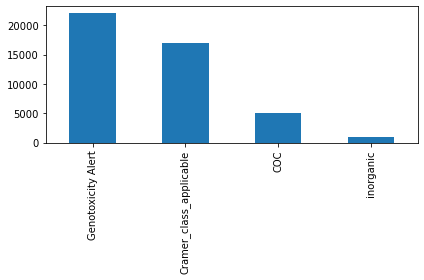

In [151]:

temp3.final_TTC_category.value_counts(dropna = True).plot.bar()

plt.tight_layout()
plt.savefig(figures_dir+ 'new_TTC_category_counts_201021.png')


#### Table 5: Re-profiled substances from the LRI dataset

In [152]:
temp3.final_TTC_category.value_counts(dropna = True)

Genotoxicity Alert         22093
Cramer_class_applicable    16940
COC                         4993
inorganic                   1012
Name: final_TTC_category, dtype: int64

In [157]:
writer = pd.ExcelWriter(interim_dir+ 'LRI_201021.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

temp3.to_excel(writer, sheet_name = 'final')



writer.save()